# Countries, Flags and Happiness
This notebook analyzes flag features versus happiness and builds a classification model.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')


In [2]:
happiness_df = pd.read_csv('WorldHappiness.csv')
flags_df = pd.read_csv('flags.csv', sep=';')

happiness_df['Country'] = happiness_df['Country'].str.strip().str.lower()
flags_df['name'] = flags_df['name'].str.strip().str.lower()

merged_df = pd.merge(happiness_df, flags_df, left_on='Country', right_on='name', how='inner')
merged_df.columns = merged_df.columns.str.strip()
print(f'Merged shape: {merged_df.shape}')


Merged shape: (104, 43)


In [3]:
median_score = merged_df['Happiness Score'].median()
merged_df['Happiness_Level'] = merged_df['Happiness Score'].apply(lambda x: 'high' if x >= median_score else 'low')
print(merged_df['Happiness_Level'].value_counts())


high    52
low     52
Name: Happiness_Level, dtype: int64


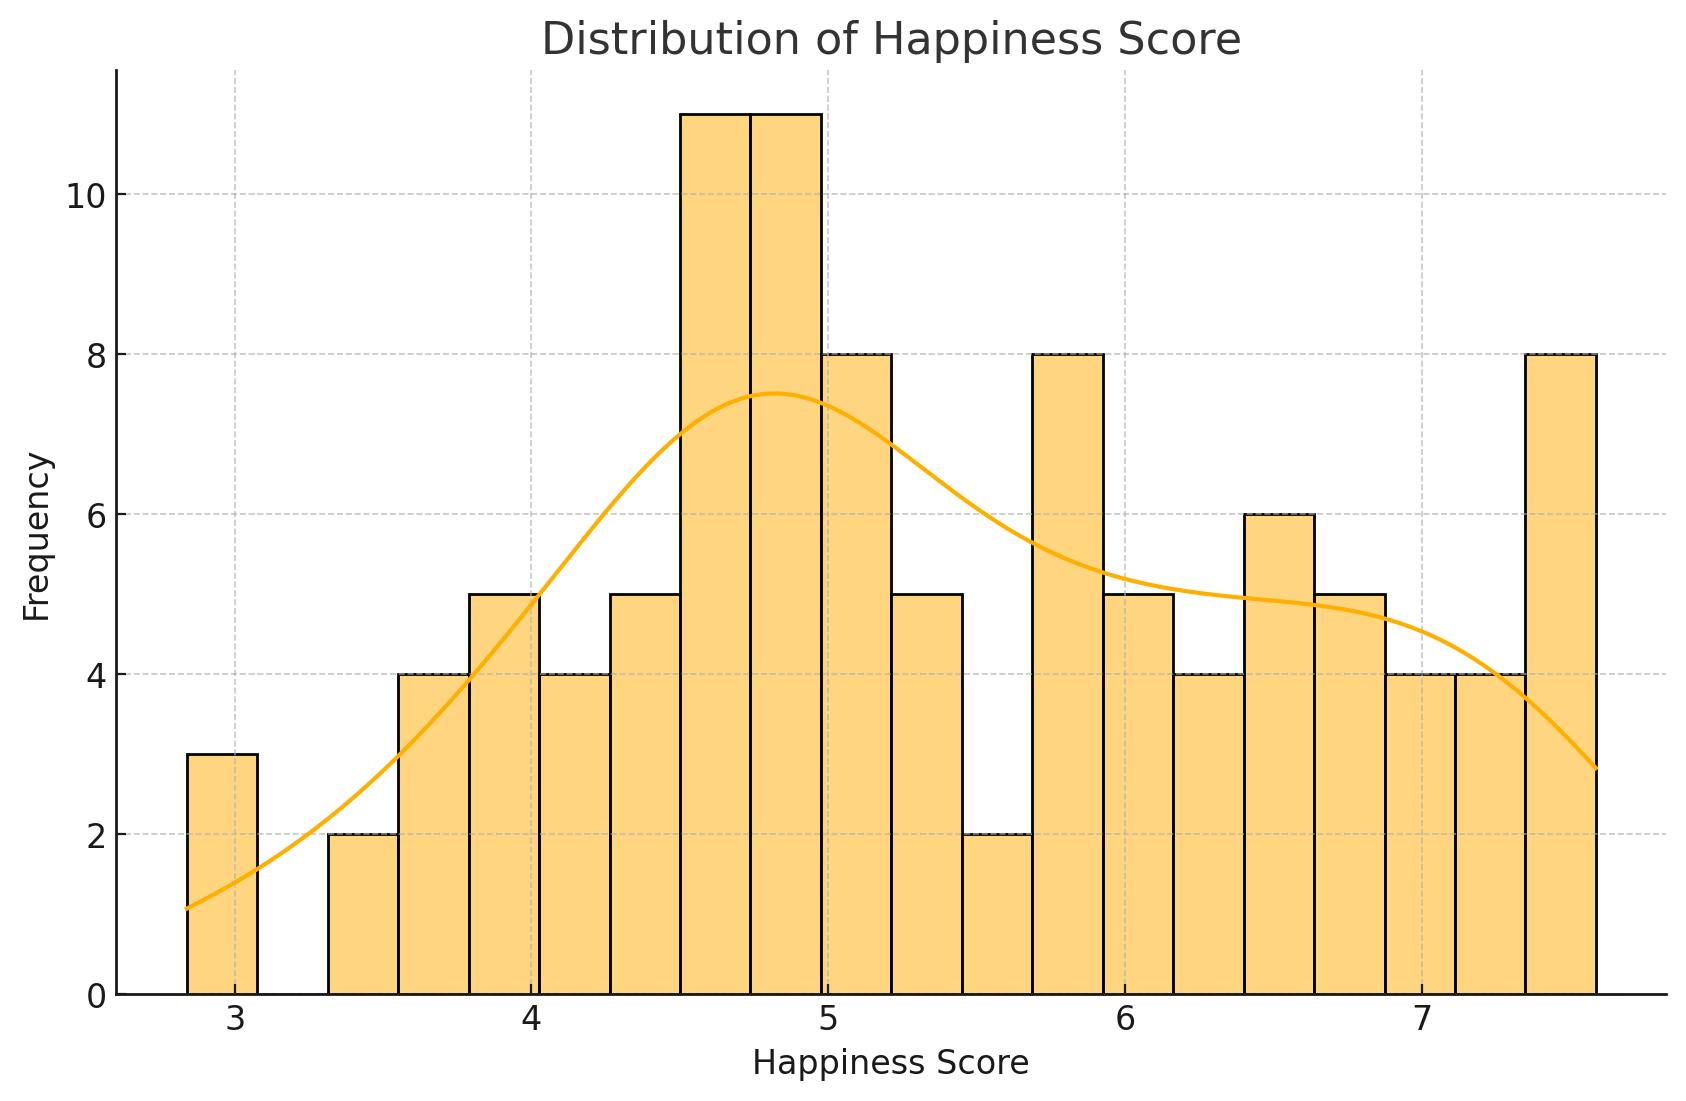

In [4]:
sns.histplot(merged_df['Happiness Score'], bins=20, kde=True)
plt.title('Distribution of Happiness Score')
plt.xlabel('Happiness Score')
plt.ylabel('Frequency')
plt.show()


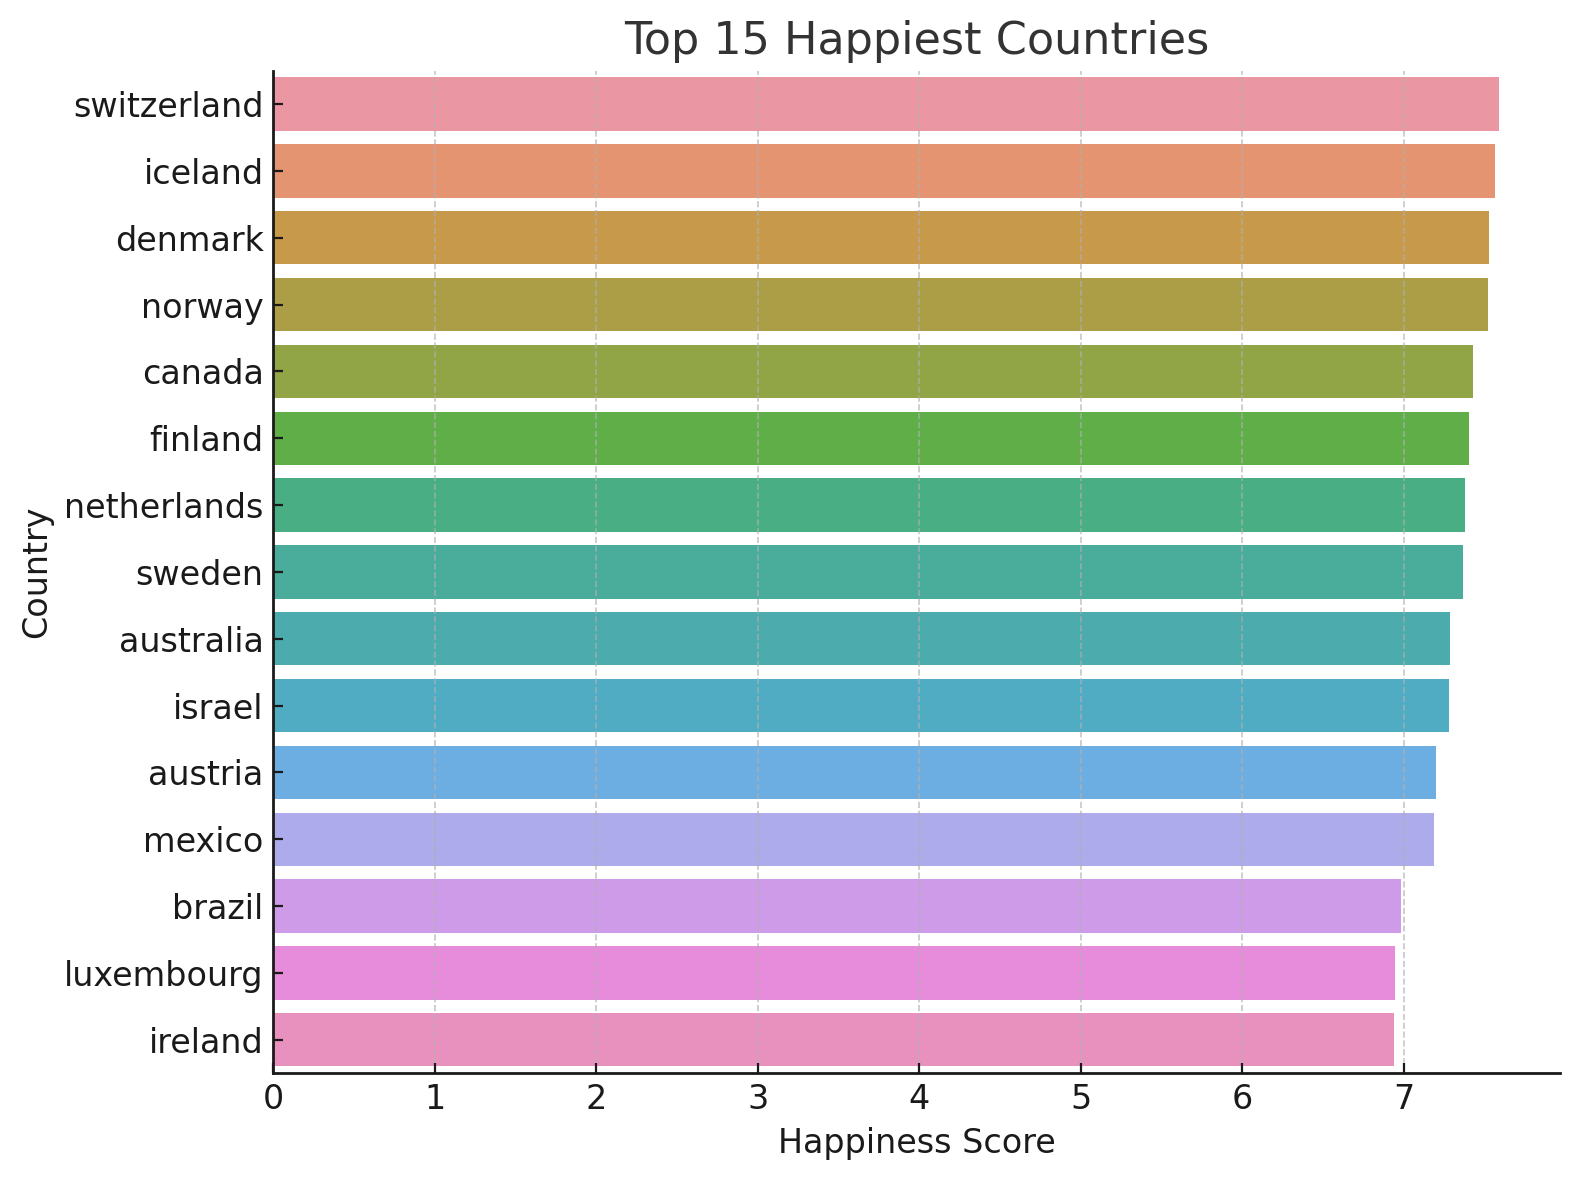

In [5]:
top15 = merged_df.sort_values(by='Happiness Score', ascending=False).head(15)
plt.figure(figsize=(8,6))
sns.barplot(data=top15, y='Country', x='Happiness Score')
plt.title('Top 15 Happiest Countries')
plt.xlabel('Happiness Score')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


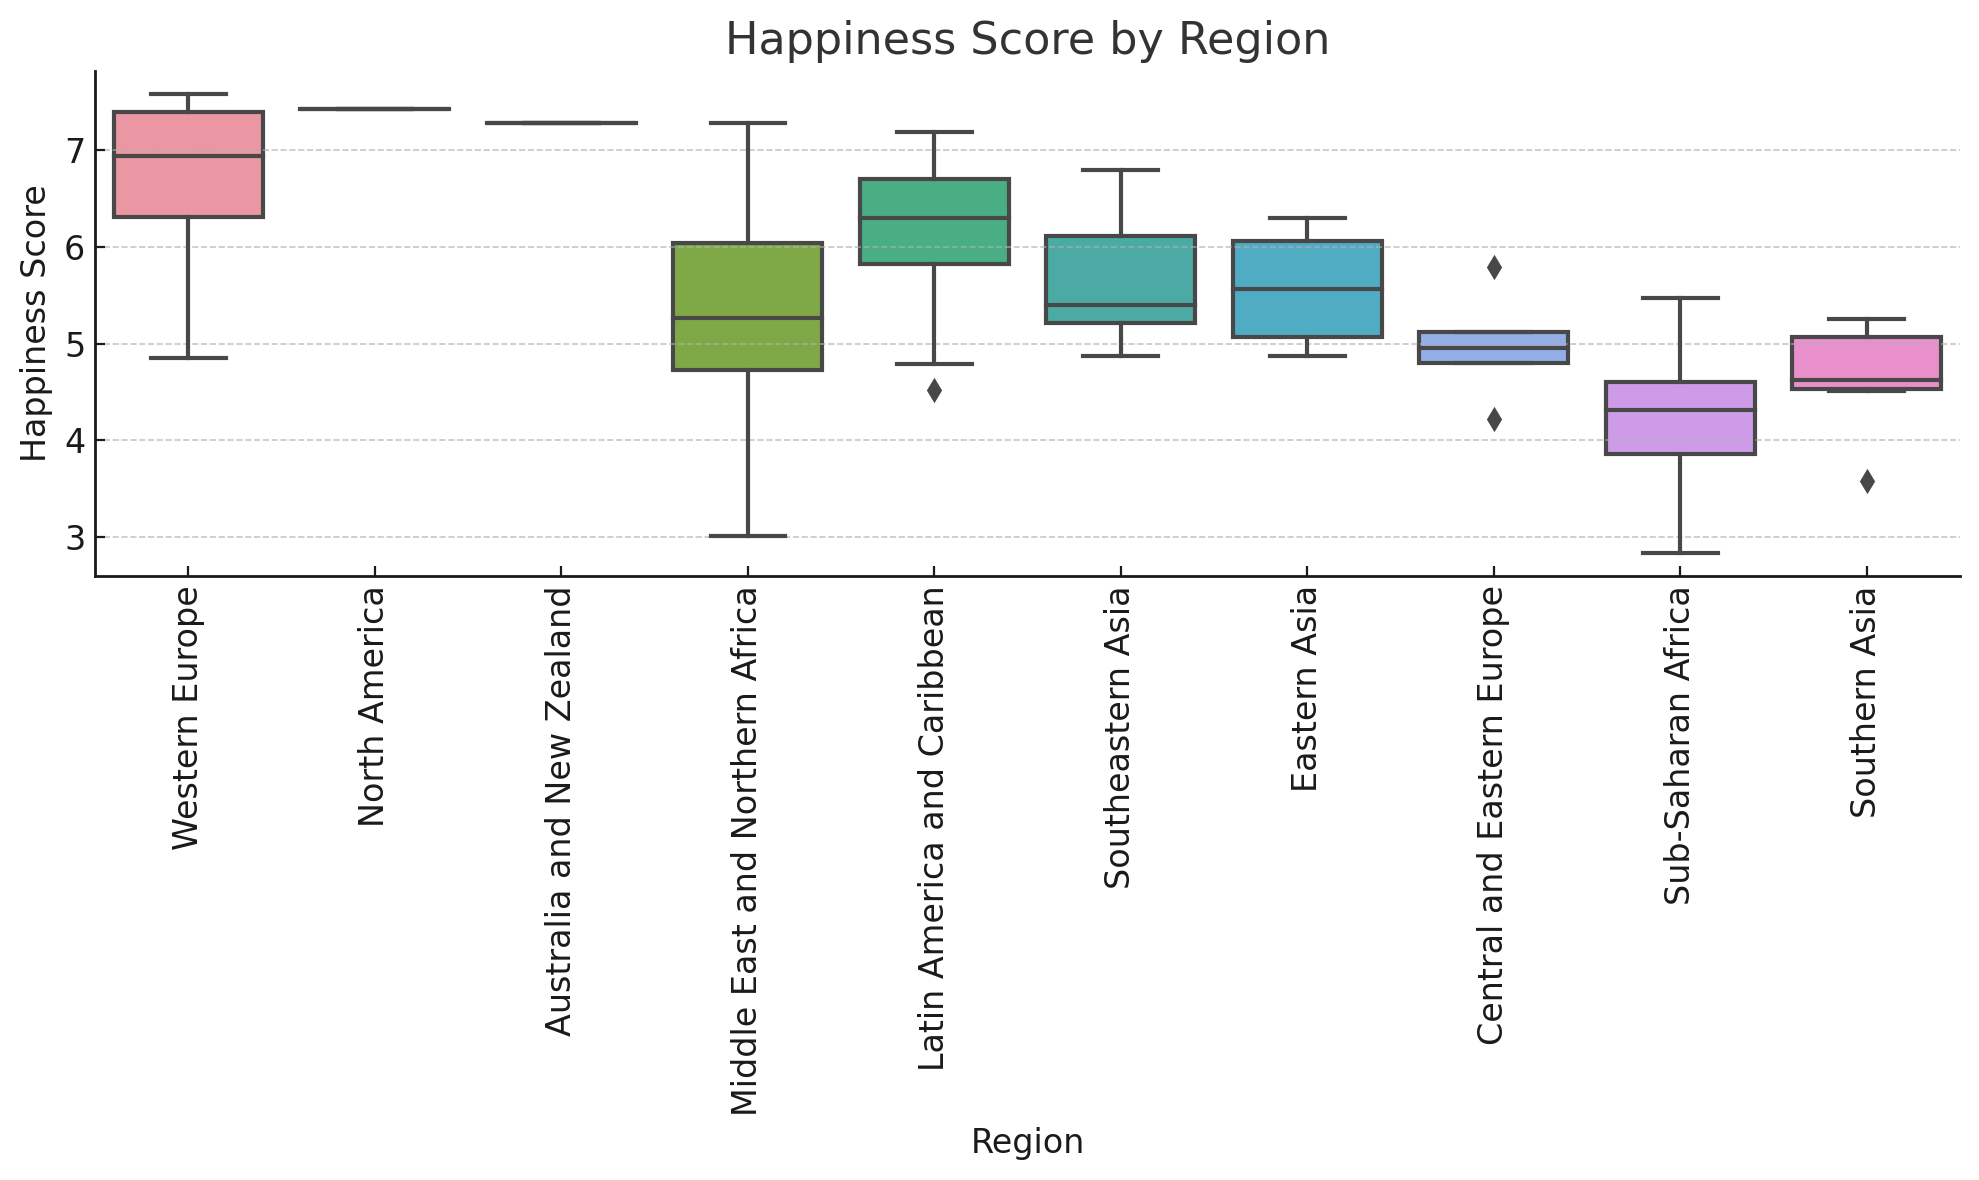

In [6]:
plt.figure(figsize=(10,6))
sns.boxplot(data=merged_df, x='Region', y='Happiness Score')
plt.title('Happiness Score by Region')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


     feature         r         p
1      green -0.451171  0.000002
8    crosses  0.416118  0.000011
5      black -0.294321  0.002424
3       gold -0.280616  0.003910
4      white  0.278674  0.004176
2       blue  0.239935  0.014158
13  triangle -0.155396  0.115219
14      icon -0.134684  0.172843
7    circles -0.123020  0.213450
10  quarters  0.119953  0.225174
11  sunstars  0.093356  0.345886
0        red -0.084700  0.392623
12  crescent -0.038929  0.694802
15   animate -0.021387  0.829379
6     orange  0.020486  0.836468
9   saltires -0.014981  0.880023


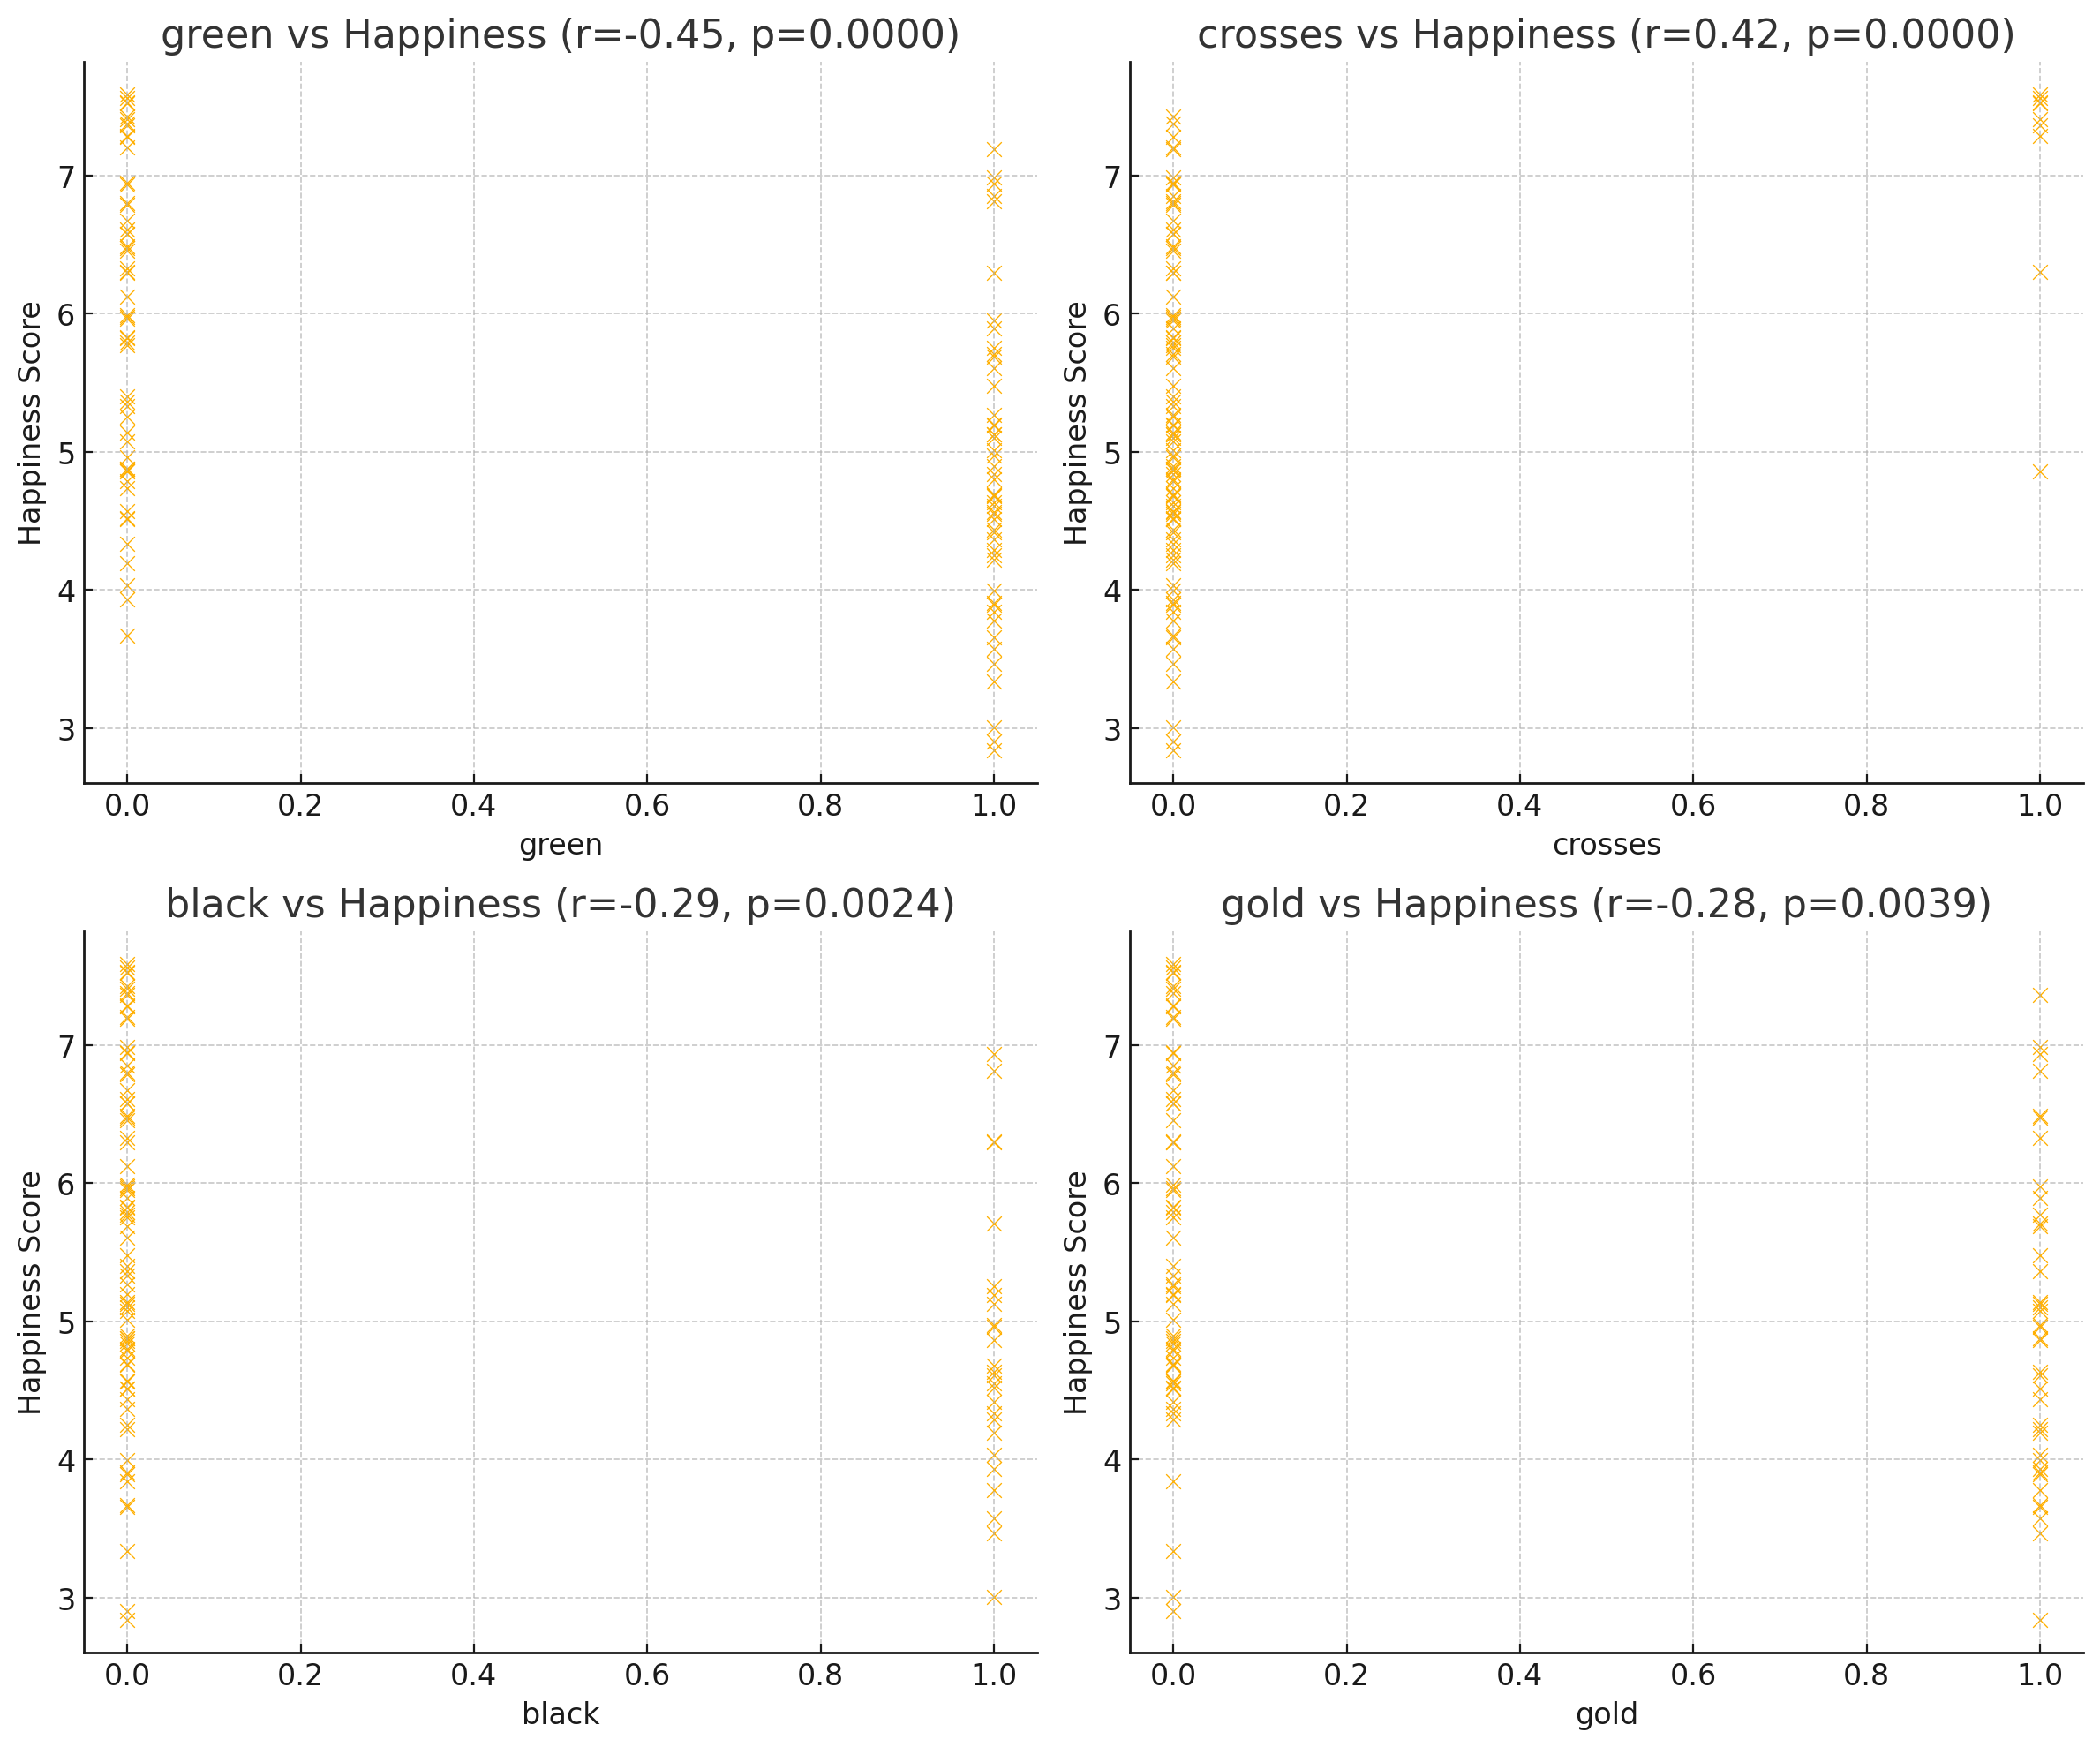

In [7]:
feature_cols = [
    'red','green','blue','gold','white','black','orange',
    'circles','crosses','saltires','quarters','sunstars',
    'crescent','triangle','icon','animate'
]
results = []
for feat in feature_cols:
    r, p = pearsonr(merged_df[feat], merged_df['Happiness Score'])
    results.append((feat, r, p))
import pandas as pd
corr_df = pd.DataFrame(results, columns=['feature','r','p']).sort_values('r', key=lambda s: s.abs(), ascending=False)
print(corr_df)

# Scatter for top4 features
top4 = corr_df['feature'].head(4)
fig, axes = plt.subplots(2,2,figsize=(12,10))
axes = axes.flatten()
for ax, feat in zip(axes, top4):
    sns.scatterplot(data=merged_df, x=feat, y='Happiness Score', ax=ax)
    ax.set_title(f"{feat} vs Happiness (r={corr_df.set_index('feature').r[feat]:.2f}, p={corr_df.set_index('feature').p[feat]:.4f})")
    ax.set_xlabel(feat)
    ax.set_ylabel('Happiness Score')
plt.tight_layout()
plt.show()


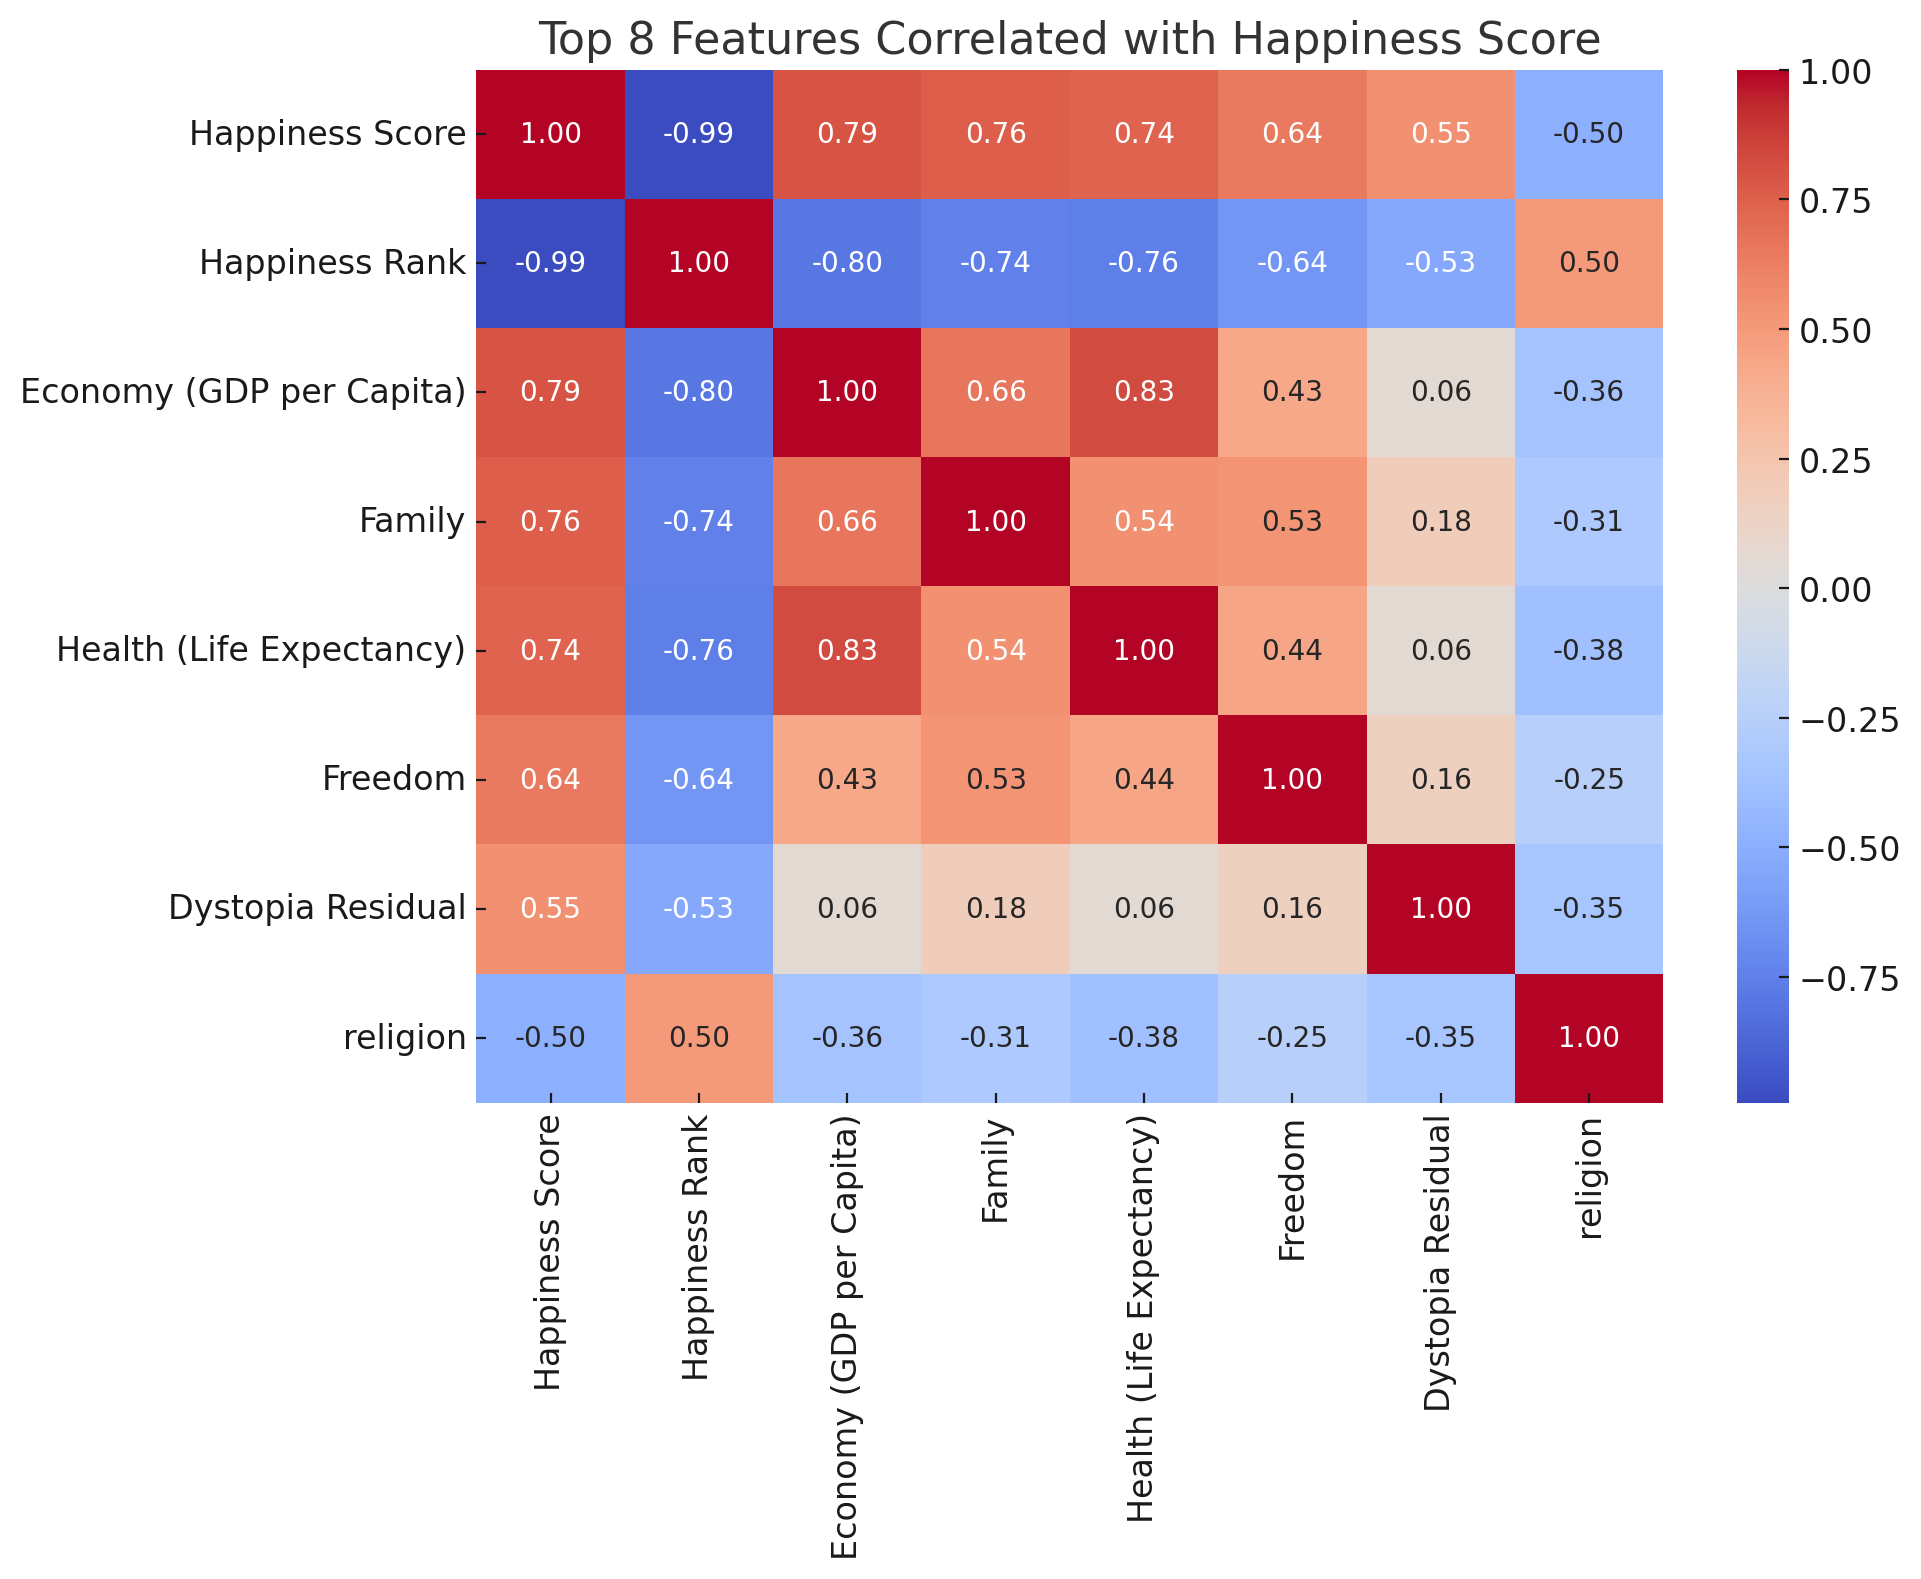

In [8]:
corr = merged_df.select_dtypes(include='number').corr()
top8 = corr['Happiness Score'].abs().sort_values(ascending=False).head(8).index
subcorr = corr.loc[top8, top8]
plt.figure(figsize=(10,8))
sns.heatmap(subcorr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Top 8 Features Correlated with Happiness Score')
plt.tight_layout()
plt.show()


In [9]:
feature_cols = ['green','blue','gold','white','black',
                'circles','crosses','saltires','quarters',
                'sunstars','crescent','triangle','icon','animate']
X = merged_df[feature_cols]
y = merged_df['Happiness_Level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.5714285714285714

Classification Report:
               precision    recall  f1-score   support

        high       0.62      0.45      0.53        11
         low       0.54      0.70      0.61        10

    accuracy                           0.57        21
   macro avg       0.58      0.58      0.57        21
weighted avg       0.58      0.57      0.57        21


Confusion Matrix:
 [[5 6]
 [3 7]]


In [10]:
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())


Cross-Validation Accuracy Scores: [0.9047619  0.42857143 0.80952381 0.66666667 0.65      ]
Mean Accuracy: 0.6919047619047618
